<a href="https://colab.research.google.com/github/tongnamuu/Tensorflow_Tutorials/blob/master/Tensorflow_tutorials_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf

import time
print(tf.__version__)

2.2.0-rc1


In [0]:
class ArtificialDataset(tf.data.Dataset):
  def _generator(num_samples):
    time.sleep(0.03)
    for sample_idx in range(num_samples):
      time.sleep(0.015)
      yield (sample_idx,)
  def __new__(cls, num_samples=3):
    return tf.data.Dataset.from_generator(
        cls._generator,
        output_types=tf.dtypes.int64,
        output_shapes=(1,),
        args=(num_samples,))

In [0]:
def benchmark(dataset, num_epochs=2):
  start_time=time.perf_counter()
  for epoch_num in range(num_epochs):
    for sample in dataset:
      time.sleep(0.01)
  tf.print(f'실행시간 : {time.perf_counter()-start_time}')

In [44]:
benchmark(ArtificialDataset())

실행시간 : 0.23346126900014497


In [45]:
benchmark(ArtificialDataset().prefetch(tf.data.experimental.AUTOTUNE))

실행시간 : 0.1915062980001494


In [46]:
benchmark(tf.data.Dataset.range(2).interleave(ArtificialDataset))

실행시간 : 0.19919049100008124


In [47]:
benchmark(tf.data.Dataset.range(2).interleave(ArtificialDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE))

실행시간 : 0.13957879800000228


In [0]:
def mapped_function(s):
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [49]:
benchmark(ArtificialDataset().map(mapped_function))

실행시간 : 0.42057961199998317


In [50]:
benchmark(ArtificialDataset().map(mapped_function, num_parallel_calls=tf.data.experimental.AUTOTUNE))

실행시간 : 0.28927591100000427


In [51]:
benchmark(ArtificialDataset().map(mapped_function).cache(),5)

실행시간 : 0.3677086349998717


In [0]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print(f'실행 시간: {time.perf_counter() - start_time}')
    
def increment(x):
    return x+1

In [53]:
fast_benchmark(fast_dataset.map(increment).batch(256))

실행 시간: 0.6317071230000693


In [54]:
fast_benchmark(fast_dataset.batch(256).map(increment))

실행 시간: 0.037499046999982966


In [0]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
class TimeMeasuredDataset(tf.data.Dataset):
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count() 
    _EPOCHS_COUNTER = defaultdict(itertools.count) 
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
  
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.
            
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

In [0]:
def timelined_benchmark(dataset, num_epochs=2):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter

            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
        
        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print(f'실행 시간: {time.perf_counter() - start_time}')
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [0]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    

    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [0]:
def map_decorator(func):
    def wrapper(steps, times, values):
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

In [0]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

In [61]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)
    time.sleep(0.0001)
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

실행 시간: 12.540100134000113


In [62]:
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0]) 
    map_elapsed = time.perf_counter() - map_enter

    return (tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
            tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
            tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1))


@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  
    map_elapsed = time.perf_counter() - map_enter
    return (tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
            tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
            tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1))


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(
        _batch_map_num_items,
        drop_remainder=True)
    .map(
        time_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()
    .map(
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

실행 시간: 6.480319749000046


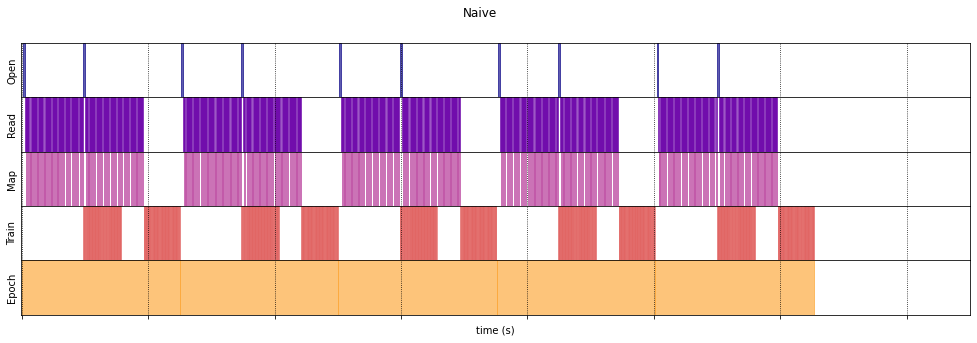

In [63]:
draw_timeline(naive_timeline, "Naive", 15)

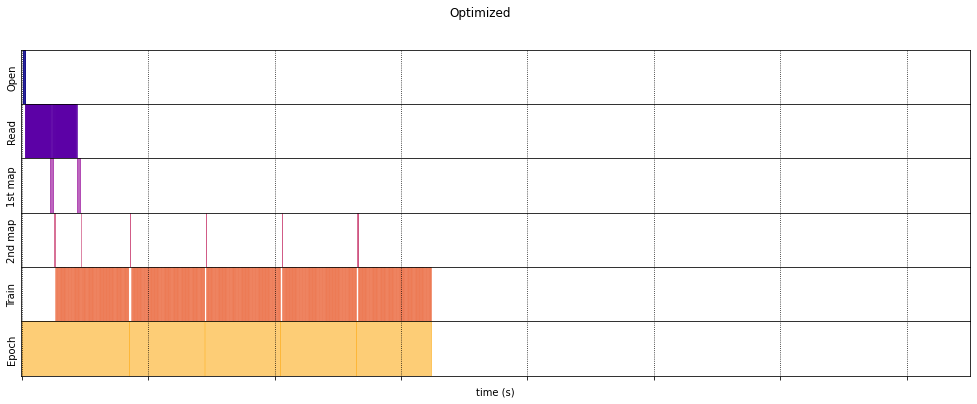

In [64]:
draw_timeline(optimized_timeline, "Optimized", 15)